<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch import nn
from scipy import special
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt

# from tensorflow.keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from tqdm import tqdm




M = 64
NN_T = 64  # Number of neurons in each hidden layer
NN_R = 64



def rrcos_time(t, beta, T):
    with np.errstate(divide='ignore', invalid='ignore'):
        rrcos = 1/T*((np.sin(np.pi*t/T*(1-beta)) +  4*beta*t/T*np.cos(np.pi*t/T*(1+beta)))/(np.pi*t/T*(1-(4*beta*t/T)**2)))
        eps = abs(t[0]-t[1])/4
        idx1 = np.where(abs(t)<eps)
        rrcos[idx1] = 1/T*(1+beta*(4/np.pi-1))
        idx2 = np.where(abs(abs(t)-abs(T/(4*beta)))<eps)
        rrcos[idx2] = beta/(T*np.sqrt(2))*((1+2/np.pi)*np.sin(np.pi/(4*beta))+(1-2/np.pi)*np.cos(np.pi/(4*beta)))
        rrcos = rrcos/np.sqrt(np.sum(rrcos**2))
    return rrcos  



def bessel(f):
    s =1.9769488898789999
    f = s*f
    return 3/(f**2+3*f+3)

def os_pulse_shaping(in_sig, pulse_shaper,os_factor=2):
    func_device='cuda' if in_sig.is_cuda else 'cpu' ### decide which device to run
    up_sig = torch.zeros((in_sig.shape[0]*os_factor,2)).to(func_device)
    up_sig[::os_factor,:]=in_sig ### upsampling by zero insertion

    I_os_sig = F.conv1d(up_sig[:,0].view(1,1,-1), pulse_shaper.to(func_device), padding=200)
    Q_os_sig = F.conv1d(up_sig[:,1].view(1,1,-1), pulse_shaper.to(func_device), padding=200)
    os_sig = torch.cat([I_os_sig.view(-1,1), Q_os_sig.view(-1,1)],-1)
    return os_sig


def DAC_freq(in_sig, sig_fb=40e9, cutoff =16e9,os_factor=2 ):
    func_device='cuda' if in_sig.is_cuda else 'cpu' ### decide which device to run
    in_freq = torch.fft(in_sig,1,True)   
    f = np.fft.fftfreq(in_freq.shape[0], 1/(sig_fb*os_factor))
    bessel_freq = bessel(1j*f/16e9)
    dac_response = torch.ones(in_freq.shape).to(func_device)
    dac_response[:,0] = torch.from_numpy(np.abs(bessel_freq)*np.sqrt(0.5)).to(func_device)
    dac_response[:,1] = torch.from_numpy(np.abs(bessel_freq)*np.sqrt(0.5)).to(func_device)
    filtered_freq = in_freq * dac_response
    return filtered_freq


def add_awgn_sigma(x, sigma):
    noise = sigma * (torch.randn(x.shape).to(device))
    x = x+noise
    return x


def DAC(x, enob, fs=40e9, cutoff=16e9,rescale_in=True ,quantizer_mode='awgn', FR_mode=False):
    """
    Function to simulate DAC response, including quantization noise (ENOB) and frequency response.
    Parameters
    ----------
    x:              Input signal, signal object.
    enob:             Efficient number of bits      (i.e. 6 bits.)
    cutoff:           3-dB cutoff frequency of DAC. (i.e. 16 GHz.)
    quantizer_model:  if quantizer_model='true', use quantizer model to simulate quantization noise.
                      if quantizer_model='False', use AWGN model to simulate quantization noise.
    out_volt:         Targeted output amplitude of the RF signal.

    Returns
    -------
    filter_sig:     Quantized and filtered output signal
    snr_enob:       signal-to-noise-ratio induced by ENOB.
    """
    powsig_mean = 2*torch.mean(torch.abs(x) ** 2) # mean power of the real signal
    
    if quantizer_mode=='quantizer':
        sig_enob_noise = quantize_signal(x, nbits=enob, rescale_in=rescale_in)
        quan_sig = sig_enob_noise
        pownoise_mean = 2*torch.mean(torch.abs(sig_enob_noise-x)**2)
        snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    elif quantizer_mode=='quantizer_awgn' :
        quan_sig = quantize_signal(x, nbits=8, rescale_in=rescale_in)
        if quan_sig.shape[1]<2:
            x_max = torch.max(torch.abs(quan_sig[:,0]))
            delta = x_max / 2**(enob-1)
            pownoise_mean = delta ** 2 / 12
            sig_enob_noise = add_awgn_sigma(quan_sig, torch.sqrt(pownoise_mean/2))
            snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB

        else:
            # Add AWGN noise due to ENOB
            x_max = torch.max(torch.max(torch.abs(quan_sig[:,0])), torch.max(torch.abs(quan_sig[:,1]))) # maximum amplitude of the signal
            delta = x_max / 2**(enob-1)
            pownoise_mean = delta ** 2 / 12
            sig_enob_noise = add_awgn_sigma(quan_sig, torch.sqrt(pownoise_mean/2))
            snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    elif quantizer_mode=='awgn':
        # Add AWGN noise due to ENOB
        x_max = torch.max(torch.max(torch.abs(x[:,0])), torch.max(torch.abs(x[:,1]))) # maximum amplitude of the signal
        delta = x_max / 2**(enob-1)
        pownoise_mean = delta ** 2 / 12
        sig_enob_noise = add_awgn_sigma(x, torch.sqrt(pownoise_mean/2))
       
        snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    else: raise ValueError("DAC mode is unknown")
    
    return sig_enob_noise




def Upsampling(in_sig_freq, os_factor=4):
    func_device='cuda' if in_sig_freq.is_cuda else 'cpu' ### decide which device to run
    pad_zeros = torch.zeros(in_sig_freq.shape[0]*(os_factor-1),2).to(func_device)
    freq_padded = torch.cat([in_sig_freq[0:int(in_sig_freq.shape[0]/2),:], pad_zeros,in_sig_freq[int(in_sig_freq.shape[0]/2):None,:]],0)
    upsampled_sig = torch.ifft(freq_padded,1, True) ### Upsampled dac signal
    return upsampled_sig

def Modulator(in_sig,des_swing=1):
    func_device='cuda' if in_sig.is_cuda else 'cpu' ### decide which device to run
    vpp = torch.tensor(np.pi/2)*des_swing
    with torch.no_grad():
        I_norm = torch.max(torch.abs(in_sig[:,0]))
        Q_norm = torch.max(torch.abs(in_sig[:,1]))
        norm=torch.max(I_norm,Q_norm)
    I_sig = in_sig[:,0] / norm * vpp
    Q_sig = in_sig[:,1] / norm * vpp
    
    I_out_sig = torch.sin(I_sig) 
    Q_out_sig = torch.sin(Q_sig)
    out_sig =torch.cat([I_out_sig.view(-1,1), Q_out_sig.view(-1,1)],-1)
    return out_sig


def Lowpass_filter(in_sig, os_rate=8):
    rx_freq = torch.fft(in_sig,1,True)
    lp_filter = torch.zeros(rx_freq.shape).to(device) 
    lp_filter[0:int(rx_freq.shape[0]/os_rate),:]=1
    lp_filter[(os_rate-1)*int(rx_freq.shape[0]/os_rate):None,:]=1
    rx_freq = rx_freq*lp_filter
    lpf_sig = torch.ifft(rx_freq,1,True)
    return lpf_sig
                 
def matched_filtering(in_sig,pulse_shaper):
    func_device='cuda' if in_sig.is_cuda else 'cpu' ### decide which device to run
    I_mf_sig1 = F.conv1d(in_sig[:,0].view(1,1,-1), pulse_shaper.to(func_device), padding=0).view(-1,1)
    Q_mf_sig1 = F.conv1d(in_sig[:,1].view(1,1,-1), pulse_shaper.to(func_device), padding=0).view(-1,1)
    mf_signal = torch.cat([I_mf_sig1,Q_mf_sig1],-1).float() 
    return mf_signal
        
                 
    
    
    

cuda


In [2]:
def add_awgn_sigma(x, sigma):
    noise = sigma * (torch.randn(x.shape).to(device))
    x = x+noise
    return x

def DAC(x, enob, fs=40e9, cutoff=16e9,rescale_in=True ,quantizer_mode='awgn', FR_mode=False):
    """
    Function to simulate DAC response, including quantization noise (ENOB) and frequency response.
    Parameters
    ----------
    x:              Input signal, signal object.
    enob:             Efficient number of bits      (i.e. 6 bits.)
    cutoff:           3-dB cutoff frequency of DAC. (i.e. 16 GHz.)
    quantizer_model:  if quantizer_model='true', use quantizer model to simulate quantization noise.
                      if quantizer_model='False', use AWGN model to simulate quantization noise.
    out_volt:         Targeted output amplitude of the RF signal.

    Returns
    -------
    filter_sig:     Quantized and filtered output signal
    snr_enob:       signal-to-noise-ratio induced by ENOB.
    """
    powsig_mean = 2*torch.mean(torch.abs(x) ** 2) # mean power of the real signal
    
    if quantizer_mode=='quantizer':
        sig_enob_noise = quantize_signal(x, nbits=enob, rescale_in=rescale_in)
        quan_sig = sig_enob_noise
        pownoise_mean = 2*torch.mean(torch.abs(sig_enob_noise-x)**2)
        snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    elif quantizer_mode=='quantizer_awgn' :
        quan_sig = quantize_signal(x, nbits=8, rescale_in=rescale_in)
        if quan_sig.shape[1]<2:
            x_max = torch.max(torch.abs(quan_sig[:,0]))
            delta = x_max / 2**(enob-1)
            pownoise_mean = delta ** 2 / 12
            sig_enob_noise = add_awgn_sigma(quan_sig, torch.sqrt(pownoise_mean/2))
            snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB

        else:
            # Add AWGN noise due to ENOB
            x_max = torch.max(torch.max(torch.abs(quan_sig[:,0])), torch.max(torch.abs(quan_sig[:,1]))) # maximum amplitude of the signal
            delta = x_max / 2**(enob-1)
            pownoise_mean = delta ** 2 / 12
            sig_enob_noise = add_awgn_sigma(quan_sig, torch.sqrt(pownoise_mean/2))
            snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    elif quantizer_mode=='awgn':
        # Add AWGN noise due to ENOB
        x_max = torch.max(torch.max(torch.abs(x[:,0])), torch.max(torch.abs(x[:,1]))) # maximum amplitude of the signal
        delta = x_max / 2**(enob-1)
        pownoise_mean = delta ** 2 / 12
        sig_enob_noise = add_awgn_sigma(x, torch.sqrt(pownoise_mean/2))
       
        snr_enob = 10*torch.log10(powsig_mean/pownoise_mean)  # unit:dB
    else: raise ValueError("DAC mode is unknown")
        
    
    return sig_enob_noise


In [3]:
train_snr=23
test_snr=23
train_sigma = torch.tensor(np.sqrt(0.5/np.power(10, train_snr/10)))
test_sigma = torch.tensor(np.sqrt(0.5/np.power(10, test_snr/10)))



fb=40e9
os=2
t = np.linspace(0, 201, 201, endpoint=False)
t -= t[(t.size-1)//2]
t /=os*fb

pulse1 = rrcos_time(t, beta=0.1, T=1/fb)
freq = np.fft.fftshift(np.fft.fft(pulse1))

p_filter = torch.from_numpy(pulse1)
p_filter = p_filter.view(1,1,-1).float()

des_swing = torch.tensor(0.99)


In [1]:
class Encoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2")
            
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))    
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))   
        x = self.layers[-1](x)
        x[:, 0] = x[:,0]- torch.mean(x[:,0])
        x[:, 1] = x[:,1]- torch.mean(x[:,1])
        x = x/ torch.sqrt(2*torch.mean(x**2))
        return x

        
class Decoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims)<2: raise ValueError("Inputs list has to be at least lenght:2") 
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    def forward(self,x):
        for i in range(len(self.layers)-1):
            x =F.relu(self.layers[i](x))
            
        x =  F.log_softmax(self.layers[-1](x), dim=-1 )
        return x

    
NN_T=50
    
clip_factor = torch.tensor(1.0, requires_grad=True) .to(device)   
class Arcsin_func(nn.Module):
    def __init__(self):
        super(Arcsin_func, self).__init__()
        self.clip_factor = torch.nn.Parameter(clip_factor,requires_grad=False)
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
#         self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, in_signal):
        aaa = torch.sign(in_signal)
       
        x1 = F.relu(self.fc1(torch.abs(in_signal)))
        x1 = F.relu(self.fc2(x1))
#         x = F.relu(self.fc3(x))
        x1 = (self.fc4(x1))   
        x1[x1>1]=1
        x1[x1<-1]=-1
        transmitted = torch.abs(x1) *aaa
        return transmitted
        


filter_shape=p_filter.shape
criterion= nn.NLLLoss()
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torch.nn.Parameter(p_filter,requires_grad=True)
#         self.weights = torch.nn.Parameter(torch.randn(p_filter.shape),requires_grad=True)

    def forward(self, x):
        new_filter = self.weights.mul(1)
        new_filter = new_filter/torch.sqrt(torch.sum(new_filter**2))
        return new_filter


    
M=64
encoder2 = Encoder(dims=[M,50,50,2]).to(device)
decoder2 = Decoder(dims=[2,50,50,M]).to(device)
my_filter = MyModel().to(device)
my_arcsin = Arcsin_func().to(device)

Path = 'AE_64QAM'
checkpoint = torch.load(Path)
encoder2.load_state_dict(checkpoint['encoder'])
decoder2.load_state_dict(checkpoint['decoder'])
# my_arcsin.load_state_dict(checkpoint['non_linear_function'])




criterion= nn.NLLLoss()


para = list(my_filter.parameters())+list(decoder2.parameters())+list(encoder2.parameters()) +list(my_arcsin.parameters()) 
# para = list(my_filter.parameters())+list(decoder2.parameters())
opt = Adam(para, lr=0.0002)
opt2 =  Adam(my_arcsin.parameters(), lr=0.0002)

NameError: name 'nn' is not defined

In [5]:
# Path = 'Filter'
# checkpoint = torch.load(Path)
# my_filter.load_state_dict(checkpoint['filter'])

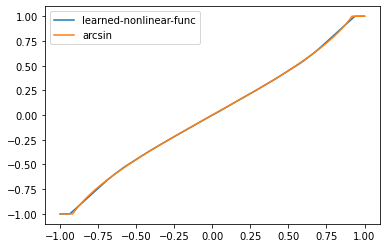

In [6]:

for i in range(1000):
    x1 = torch.from_numpy(np.linspace(-1,1,10000)).float().to(device)
    x1= x1.view(-1,1)
    
    y1 = torch.asin(x1)/torch.tensor(np.pi/2)*1.35
    y_pred = my_arcsin(x1)
#     print(y_pred.shape)
    loss = torch.mean((y_pred-y1)**2)
    
    opt2.zero_grad()     
    loss.backward(retain_graph=True)
    opt2.step()
    
x1 = torch.from_numpy(np.linspace(-1,1,10000)).float().to(device)
x1= x1.view(-1,1)    
a = torch.tensor(np.linspace(-1,1,10000)).view(-1,1).float().to(device)
arc1= my_arcsin(x1).to(device)
eee = torch.asin(a).to('cpu').detach().numpy()/(np.pi/2)*1.35
eee[eee>=1]=1
eee[eee<=-1]=-1
# eee = eee/np.max(np.abs(eee)) *np.pi/2



c = a.detach().to('cpu').detach().numpy()
arc1 = arc1.detach().to('cpu').detach().numpy()


plt.plot(c,arc1,label='learned-nonlinear-func')
plt.plot(c,eee, label='arcsin')

# plt.plot(c,2.4*c, label=' straight-line')
plt.legend()



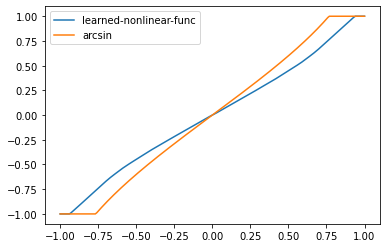

In [7]:
x1 = torch.from_numpy(np.linspace(-1,1,200)).float().to(device)
x1= x1.view(-1,1)    
a = torch.tensor(np.linspace(-1,1,200)).view(-1,1).float().to(device)
arc1= my_arcsin(x1).to(device)
eee = torch.asin(a).to('cpu').detach().numpy()/(np.pi/2)*1.8
eee[eee>=1]=1
eee[eee<=-1]=-1
# eee = eee/np.max(np.abs(eee)) *np.pi/2



c = a.detach().to('cpu').detach().numpy()
arc1 = arc1.detach().to('cpu').detach().numpy()


plt.plot(c,arc1,label='learned-nonlinear-func')
plt.plot(c,eee, label='arcsin')

# plt.plot(c,2.4*c, label=' straight-line')
plt.legend()



In [8]:

gb_factor=1.04

train_loss = np.array([])

grad_steps=2

batch_size = 16000
t=tqdm(range(1, grad_steps+1), desc='grad_step')
for I in t:
    t.set_description('gradiant_step = {}'.format(I))
    
    torch.cuda.empty_cache()
    train_filter = my_filter(1)
    
    tx_mess1 = torch.from_numpy(np.random.randint(0,M, batch_size)).to(device)
    tx_mess2 = torch.from_numpy(np.random.randint(0,M, batch_size)).to(device)
    tx_mess3 = torch.from_numpy(np.random.randint(0,M, batch_size)).to(device)
    one_hot1 = F.one_hot(tx_mess1).float() 
    one_hot2 = F.one_hot(tx_mess2).float() 
    one_hot3 = F.one_hot(tx_mess3).float() 
    sig1 = encoder2(one_hot1)     
    sig2 = encoder2(one_hot2)   
    sig3 = encoder2(one_hot3)   
    
    

    ps_signal1 = os_pulse_shaping(in_sig=sig1, pulse_shaper=train_filter ,os_factor=os)
    ps_signal2 = os_pulse_shaping(in_sig=sig2, pulse_shaper=train_filter ,os_factor=os)
    ps_signal3 = os_pulse_shaping(in_sig=sig3, pulse_shaper=train_filter ,os_factor=os)
    
    
    
    
    clip_lvl=1.0
#     I_shaped_sig1 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal1[:,0]/torch.max(torch.abs(ps_signal1[:,0]))
#     Q_shaped_sig1 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal1[:,1]/torch.max(torch.abs(ps_signal1[:,1]))  
#     I_shaped_sig1 = torch.asin(I_shaped_sig1.view(-1,1))
#     Q_shaped_sig1 = torch.asin(Q_shaped_sig1.view(-1,1))
#     I_clipped_sig1 = I_shaped_sig1/torch.max(torch.abs(I_shaped_sig1))*torch.tensor(clip_lvl)
#     Q_clipped_sig1 = Q_shaped_sig1/torch.max(torch.abs(Q_shaped_sig1))*torch.tensor(clip_lvl)
#     I_clipped_sig1[I_clipped_sig1>=1]=1
#     I_clipped_sig1[I_clipped_sig1<=-1]=-1
#     Q_clipped_sig1[Q_clipped_sig1>=1]=1
#     Q_clipped_sig1[Q_clipped_sig1<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal1[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal1[:,1]))
    peak_value1 = torch.max(I_peak, Q_peak) 
    I_clipped_sig1 = my_arcsin(ps_signal1[:,0].view(-1,1)/peak_value1)
    Q_clipped_sig1 = my_arcsin(ps_signal1[:,1].view(-1,1)/peak_value1)
    arcsin_sig1 = torch.cat([I_clipped_sig1.view(-1,1), Q_clipped_sig1.view(-1,1)],-1)  
    
#     I_shaped_sig2 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal2[:,0]/torch.max(torch.abs(ps_signal2[:,0]))
#     Q_shaped_sig2 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal2[:,1]/torch.max(torch.abs(ps_signal2[:,1]))  
#     I_shaped_sig2 = torch.asin(I_shaped_sig2.view(-1,1))
#     Q_shaped_sig2 = torch.asin(Q_shaped_sig2.view(-1,1)) 
#     I_clipped_sig2 = I_shaped_sig2/torch.max(torch.abs(I_shaped_sig2))*torch.tensor(clip_lvl)
#     Q_clipped_sig2 = Q_shaped_sig2/torch.max(torch.abs(Q_shaped_sig2))*torch.tensor(clip_lvl)
#     I_clipped_sig2[I_clipped_sig2>=1]=1
#     I_clipped_sig2[I_clipped_sig2<=-1]=-1
#     Q_clipped_sig2[Q_clipped_sig2>=1]=1
#     Q_clipped_sig2[Q_clipped_sig2<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal2[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal2[:,1]))
    peak_value2 = torch.max(I_peak, Q_peak)
   
    
    I_clipped_sig2 = my_arcsin(ps_signal2[:,0].view(-1,1)/peak_value2)
    Q_clipped_sig2 = my_arcsin(ps_signal2[:,1].view(-1,1)/peak_value2)
    arcsin_sig2 = torch.cat([I_clipped_sig2.view(-1,1), Q_clipped_sig2.view(-1,1)],-1)  
    
#     I_shaped_sig3 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal3[:,0]/torch.max(torch.abs(ps_signal3[:,0]))
#     Q_shaped_sig3 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal3[:,1]/torch.max(torch.abs(ps_signal3[:,1]))  
#     I_shaped_sig3 = torch.asin(I_shaped_sig3.view(-1,1))
#     Q_shaped_sig3 = torch.asin(Q_shaped_sig3.view(-1,1))
#     I_clipped_sig3 = I_shaped_sig3/torch.max(torch.abs(I_shaped_sig3))*torch.tensor(clip_lvl)
#     Q_clipped_sig3 = Q_shaped_sig3/torch.max(torch.abs(Q_shaped_sig3))*torch.tensor(clip_lvl)
#     I_clipped_sig3[I_clipped_sig3>=1]=1
#     I_clipped_sig3[I_clipped_sig3<=-1]=-1
#     Q_clipped_sig3[Q_clipped_sig3>=1]=1
#     Q_clipped_sig3[Q_clipped_sig3<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal3[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal3[:,1]))
    peak_value3 = torch.max(I_peak, Q_peak)
    
    I_clipped_sig3 = my_arcsin(ps_signal3[:,0].view(-1,1)/peak_value3)
    Q_clipped_sig3 = my_arcsin(ps_signal3[:,1].view(-1,1)/peak_value3)
    arcsin_sig3 = torch.cat([I_clipped_sig3.view(-1,1), Q_clipped_sig3.view(-1,1)],-1)  
    
    
    
    
    up_factor=4
    ps_freq1 = torch.fft(arcsin_sig1,1,True)
    up_sig1 = Upsampling(in_sig_freq=ps_freq1, os_factor=up_factor)
    arcsin_sig1 = up_sig1*2
    
    
    
    ps_freq2 = torch.fft(arcsin_sig2,1,True)
    up_sig2 = Upsampling(in_sig_freq=ps_freq2, os_factor=up_factor)
    arcsin_sig2 = up_sig2*2

    ps_freq3 = torch.fft(arcsin_sig3,1,True)
    up_sig3 = Upsampling(in_sig_freq=ps_freq3, os_factor=up_factor)
    arcsin_sig3 = up_sig3*2
    
    enob = 6
    dac_sig1 = DAC(arcsin_sig1, enob)
    dac_sig2 = DAC(arcsin_sig2, enob)
    dac_sig3 = DAC(arcsin_sig3, enob)

#     dac_sig1 = arcsin_sig1
#     dac_sig2 = arcsin_sig2
#     dac_sig3 = arcsin_sig3
    
   


    
#     dac_sig_freq1 = torch.fft(dac_sig1,1,True)
#     dac_sig_freq2 = torch.fft(dac_sig2,1,True)
#     dac_sig_freq3 = torch.fft(dac_sig3,1,True)
    
#     dac_sig1= torch.ifft(dac_sig_freq1,1,True)
#     dac_sig2= torch.ifft(dac_sig_freq2,1,True)
#     dac_sig3= torch.ifft(dac_sig_freq3,1,True)
    
    
    
    
    
    mod_sig1 = Modulator(in_sig=dac_sig1,des_swing= des_swing)
    mod_sig2 = Modulator(in_sig=dac_sig2, des_swing=des_swing)
    mod_sig3 = Modulator(in_sig=dac_sig3,des_swing=des_swing)
    
    
    

    ############ Modulate baseband signal onto different carriers
    sig_carrier1 = mod_sig1
    
    
    
    fc_left=torch.tensor(-gb_factor*np.pi*2*np.arange(sig_carrier1.shape[0])/(os*4)).to(device)
    fc_right=torch.tensor(gb_factor*np.pi*2*np.arange(sig_carrier1.shape[0])/(os*4)).to(device)
    I_sig2 = mod_sig2[:,0]*torch.cos(fc_left) - mod_sig2[:,1]*torch.sin(fc_left)
    Q_sig2 = mod_sig2[:,0]*torch.sin(fc_left) + mod_sig2[:,1]*torch.cos(fc_left)
#     I_sig2 = mod_sig2[:,0]*torch.cos(fc_left) 
#     Q_sig2 = mod_sig2[:,1]*torch.sin(fc_left) 
    sig_carrier2 = torch.cat([I_sig2.view(-1,1), Q_sig2.view(-1,1)],-1)
    


    I_sig3 = mod_sig3[:,0]*torch.cos(fc_right) - mod_sig3[:,1]*torch.sin(fc_right)
    Q_sig3 = mod_sig3[:,0]*torch.sin(fc_right) + mod_sig3[:,1]*torch.cos(fc_right)
#     I_sig3 = mod_sig3[:,0]*torch.cos(fc_right) 
#     Q_sig3 = mod_sig3[:,1]*torch.sin(fc_right) 
    sig_carrier3 = torch.cat([I_sig3.view(-1,1), Q_sig3.view(-1,1)],-1)
    
    
    wdm_sig = sig_carrier1+sig_carrier2+sig_carrier3
    rx_wdm_sig = wdm_sig + (torch.randn(wdm_sig.shape)*train_sigma).to(device)
        
    
    ####### Demodulate all channels back to baseband signal
    
    ###### first channel ####
    rx_sig1 = rx_wdm_sig
    #### Low Pass Filter: Simulate ADC
    rec_signal1 = Lowpass_filter(in_sig=rx_sig1, os_rate=8)
    ## Down samping
    down_sig1=rec_signal1[::4,:]
    
        
    
    ##### Second channel #######
    ## Base band
    I_sig2 = rx_wdm_sig[:,0]*torch.cos(fc_right) - rx_wdm_sig[:,1]*torch.sin(fc_right)
    Q_sig2 = rx_wdm_sig[:,0]*torch.sin(fc_right) + rx_wdm_sig[:,1]*torch.cos(fc_right)
#     I_sig2 = rx_wdm_sig[:,0]*torch.cos(fc_right) 
#     Q_sig2 = rx_wdm_sig[:,1]*torch.sin(fc_right)
    rx_sig2 = torch.cat([I_sig2.view(-1,1), Q_sig2.view(-1,1)],-1)
    ## Low pass filtering
    rec_signal2 = Lowpass_filter(in_sig=rx_sig2, os_rate=8)
    ## Down samping
    down_sig2=rec_signal2[::4,:]
    
    
    ##### Third channel #######
    ## Base band
    I_sig3 = rx_wdm_sig[:,0]*torch.cos(fc_left) - rx_wdm_sig[:,1]*torch.sin(fc_left)
    Q_sig3 = rx_wdm_sig[:,0]*torch.sin(fc_left) + rx_wdm_sig[:,1]*torch.cos(fc_left)
#     I_sig3 = rx_wdm_sig[:,0]*torch.cos(fc_left) 
#     Q_sig3 = rx_wdm_sig[:,1]*torch.sin(fc_left) 
    rx_sig3 = torch.cat([I_sig3.view(-1,1), Q_sig3.view(-1,1)],-1)
    ## Low pass filtering
    rec_signal3= Lowpass_filter(in_sig=rx_sig3, os_rate=8)
    ## Down samping
    down_sig3=rec_signal3[::4,:]
    
    
    
   
    mf_signal1=matched_filtering(down_sig1.float(), pulse_shaper=p_filter)
    mf_signal2=matched_filtering(down_sig2.float(), pulse_shaper=p_filter)
    mf_signal3=matched_filtering(down_sig3.float(), pulse_shaper=p_filter)
    
        
    down_sig1 =mf_signal1[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig1**2))
    down_sig1 =down_sig1/new_norm1
    y_pred1 = decoder2(down_sig1)
    
    down_sig2 =mf_signal2[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig2**2))
    down_sig2 =down_sig2/new_norm1
    y_pred2 = decoder2(down_sig2)
    
    down_sig3 =mf_signal3[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig3**2))
    down_sig3 =down_sig3/new_norm1
    y_pred3 = decoder2(down_sig3)
    
    
    
    
    loss = criterion(y_pred1, tx_mess1)
#     loss = my_loss(y_pred1, tx_mess1,sig_carrier1)
    opt.zero_grad()     
    loss.backward(retain_graph=True)
    opt.step()
    loss_n = loss.to('cpu').detach().numpy()
    train_loss = np.append(train_loss, loss_n)
   




gradiant_step = 1:   0%|          | 0/2 [00:00<?, ?it/s]/home/jinxiang/miniconda3/envs/superchannel/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:567.)
/home/jinxiang/miniconda3/envs/superchannel/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/SpectralOps.cpp:578.)
gradiant_step = 2: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


In [9]:
criterion(y_pred2, tx_mess2)

tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward>)

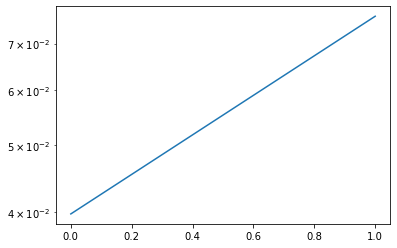

In [10]:
plt.semilogy(train_loss)

In [18]:
rx = wdm_sig.to('cpu').detach().numpy()

freq0 = torch.fft(rx_wdm_sig,1,True).to('cpu').detach().numpy()
freq0 = np.fft.fftshift(freq0[:,0]+1j*freq0[:,1])
freq0 = np.fft.fftshift(np.fft.fft(rx[:,0]+1j*rx[:,1], axis=-1 ))

rx2 = sig_carrier2.view(-1).to('cpu').detach().numpy()


freq1 = np.fft.fftshift(np.fft.fft(rx2[:,0]+1j*rx2[:,1] ))

plt.plot(np.linspace(-4,4, freq0.shape[0]), 20*np.log10(np.abs(freq0)))
plt.plot(np.linspace(-4,4, freq0.shape[0]), 20*np.log10(np.abs(freq1)))

# plt.plot(20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq)))
# plt.plot(20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq0)))

# print((20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq)))[0:100])

(257600,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

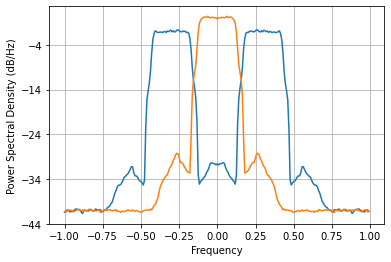

In [14]:
rx = sig_carrier1.to('cpu').detach().numpy()
a = plt.psd(rx2[:,0]+1j*rx2[:,0] )
b = a = plt.psd(rx[:,0]+1j*rx[:,1] ) 

In [15]:
# gb_factor=1.06
# train_filter = my_filter(1)
ser_iter=10
SER1 = 0
SER2 = 0
SER3 = 0


for ttt in np.arange(ser_iter):
    torch.cuda.empty_cache()
    tx_mess1 = torch.from_numpy(np.random.randint(0,M, 64000)).to(device)
    tx_mess2 = torch.from_numpy(np.random.randint(0,M, 64000)).to(device)
    tx_mess3 = torch.from_numpy(np.random.randint(0,M, 64000)).to(device)
    one_hot1 = F.one_hot(tx_mess1).float() 
    one_hot2 = F.one_hot(tx_mess2).float() 
    one_hot3 = F.one_hot(tx_mess3).float() 
    sig1 = encoder2(one_hot1)     
    sig2 = encoder2(one_hot2)   
    sig3 = encoder2(one_hot3)   
    
    tmp = train_filter

    ps_signal1 = os_pulse_shaping(in_sig=sig1, pulse_shaper=tmp ,os_factor=os)
    ps_signal2 = os_pulse_shaping(in_sig=sig2, pulse_shaper=tmp ,os_factor=os)
    ps_signal3 = os_pulse_shaping(in_sig=sig3, pulse_shaper=tmp ,os_factor=os)
    
    
#     clip_lvl=1.0
#     I_shaped_sig1 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal1[:,0]/torch.max(torch.abs(ps_signal1[:,0]))
#     Q_shaped_sig1 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal1[:,1]/torch.max(torch.abs(ps_signal1[:,1]))  
#     I_shaped_sig1 = torch.asin(I_shaped_sig1.view(-1,1))
#     Q_shaped_sig1 = torch.asin(Q_shaped_sig1.view(-1,1))
#     I_clipped_sig1 = I_shaped_sig1/torch.max(torch.abs(I_shaped_sig1))*torch.tensor(clip_lvl)
#     Q_clipped_sig1 = Q_shaped_sig1/torch.max(torch.abs(Q_shaped_sig1))*torch.tensor(clip_lvl)
#     I_clipped_sig1[I_clipped_sig1>=1]=1
#     I_clipped_sig1[I_clipped_sig1<=-1]=-1
#     Q_clipped_sig1[Q_clipped_sig1>=1]=1
#     Q_clipped_sig1[Q_clipped_sig1<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal1[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal1[:,1]))
    peak_value1 = torch.max(I_peak, Q_peak) 
    I_clipped_sig1 = my_arcsin(ps_signal1[:,0].view(-1,1)/peak_value1)
    Q_clipped_sig1 = my_arcsin(ps_signal1[:,1].view(-1,1)/peak_value1)
    arcsin_sig1 = torch.cat([I_clipped_sig1.view(-1,1), Q_clipped_sig1.view(-1,1)],-1)  
    
#     I_shaped_sig2 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal2[:,0]/torch.max(torch.abs(ps_signal2[:,0]))
#     Q_shaped_sig2 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal2[:,1]/torch.max(torch.abs(ps_signal2[:,1]))  
#     I_shaped_sig2 = torch.asin(I_shaped_sig2.view(-1,1))
#     Q_shaped_sig2 = torch.asin(Q_shaped_sig2.view(-1,1)) 
#     I_clipped_sig2 = I_shaped_sig2/torch.max(torch.abs(I_shaped_sig2))*torch.tensor(clip_lvl)
#     Q_clipped_sig2 = Q_shaped_sig2/torch.max(torch.abs(Q_shaped_sig2))*torch.tensor(clip_lvl)
#     I_clipped_sig2[I_clipped_sig2>=1]=1
#     I_clipped_sig2[I_clipped_sig2<=-1]=-1
#     Q_clipped_sig2[Q_clipped_sig2>=1]=1
#     Q_clipped_sig2[Q_clipped_sig2<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal2[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal2[:,1]))
    peak_value2 = torch.max(I_peak, Q_peak)
   
    
    I_clipped_sig2 = my_arcsin(ps_signal2[:,0].view(-1,1)/peak_value2)
    Q_clipped_sig2 = my_arcsin(ps_signal2[:,1].view(-1,1)/peak_value2)
    arcsin_sig2 = torch.cat([I_clipped_sig2.view(-1,1), Q_clipped_sig2.view(-1,1)],-1)  
    
#     I_shaped_sig3 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal3[:,0]/torch.max(torch.abs(ps_signal3[:,0]))
#     Q_shaped_sig3 = torch.sin(des_swing*torch.tensor(np.pi/2))*ps_signal3[:,1]/torch.max(torch.abs(ps_signal3[:,1]))  
#     I_shaped_sig3 = torch.asin(I_shaped_sig3.view(-1,1))
#     Q_shaped_sig3 = torch.asin(Q_shaped_sig3.view(-1,1))
#     I_clipped_sig3 = I_shaped_sig3/torch.max(torch.abs(I_shaped_sig3))*torch.tensor(clip_lvl)
#     Q_clipped_sig3 = Q_shaped_sig3/torch.max(torch.abs(Q_shaped_sig3))*torch.tensor(clip_lvl)
#     I_clipped_sig3[I_clipped_sig3>=1]=1
#     I_clipped_sig3[I_clipped_sig3<=-1]=-1
#     Q_clipped_sig3[Q_clipped_sig3>=1]=1
#     Q_clipped_sig3[Q_clipped_sig3<=-1]=-1

    I_peak = torch.max(torch.abs(ps_signal3[:,0]))
    Q_peak = torch.max(torch.abs(ps_signal3[:,1]))
    peak_value3 = torch.max(I_peak, Q_peak)
    
    I_clipped_sig3 = my_arcsin(ps_signal3[:,0].view(-1,1)/peak_value3)
    Q_clipped_sig3 = my_arcsin(ps_signal3[:,1].view(-1,1)/peak_value3)
    arcsin_sig3 = torch.cat([I_clipped_sig3.view(-1,1), Q_clipped_sig3.view(-1,1)],-1)  
    
    
    
    
    
    up_factor=4
    ps_freq1 = torch.fft(arcsin_sig1,1,True)
    up_sig1 = Upsampling(in_sig_freq=ps_freq1, os_factor=up_factor)
    arcsin_sig1 = up_sig1*2
    
    
    
    ps_freq2 = torch.fft(arcsin_sig2,1,True)
    up_sig2 = Upsampling(in_sig_freq=ps_freq2, os_factor=up_factor)
    arcsin_sig2 = up_sig2*2

    ps_freq3 = torch.fft(arcsin_sig3,1,True)
    up_sig3 = Upsampling(in_sig_freq=ps_freq3, os_factor=up_factor)
    arcsin_sig3 = up_sig3*2
    
    enob = 6
    dac_sig1 = DAC(arcsin_sig1, enob)
    dac_sig2 = DAC(arcsin_sig2, enob)
    dac_sig3 = DAC(arcsin_sig3, enob)

#     dac_sig1 = arcsin_sig1
#     dac_sig2 = arcsin_sig2
#     dac_sig3 = arcsin_sig3
    
   


    
#     dac_sig_freq1 = torch.fft(dac_sig1,1,True)
#     dac_sig_freq2 = torch.fft(dac_sig2,1,True)
#     dac_sig_freq3 = torch.fft(dac_sig3,1,True)
    
#     dac_sig1= torch.ifft(dac_sig_freq1,1,True)
#     dac_sig2= torch.ifft(dac_sig_freq2,1,True)
#     dac_sig3= torch.ifft(dac_sig_freq3,1,True)
    
    
    
    
    
    mod_sig1 = Modulator(in_sig=dac_sig1,des_swing= des_swing)
    mod_sig2 = Modulator(in_sig=dac_sig2, des_swing=des_swing)
    mod_sig3 = Modulator(in_sig=dac_sig3,des_swing=des_swing)
    
    
    

    ############ Modulate baseband signal onto different carriers
    sig_carrier1 = mod_sig1
    fc_left=torch.tensor(-gb_factor*np.pi*2*np.arange(sig_carrier1.shape[0])/(os*4)).to(device)
    fc_right=torch.tensor(gb_factor*np.pi*2*np.arange(sig_carrier1.shape[0])/(os*4)).to(device)

    I_sig2 = mod_sig2[:,0]*torch.cos(fc_left) - mod_sig2[:,1]*torch.sin(fc_left)
    Q_sig2 = mod_sig2[:,0]*torch.sin(fc_left) + mod_sig2[:,1]*torch.cos(fc_left)
#     I_sig2 = mod_sig2[:,0]*torch.cos(fc_left) 
#     Q_sig2 = mod_sig2[:,1]*torch.sin(fc_left) 
    sig_carrier2 = torch.cat([I_sig2.view(-1,1), Q_sig2.view(-1,1)],-1)
    


    I_sig3 = mod_sig3[:,0]*torch.cos(fc_right) - mod_sig3[:,1]*torch.sin(fc_right)
    Q_sig3 = mod_sig3[:,0]*torch.sin(fc_right) + mod_sig3[:,1]*torch.cos(fc_right)
#     I_sig3 = mod_sig3[:,0]*torch.cos(fc_right) 
#     Q_sig3 = mod_sig3[:,1]*torch.sin(fc_right) 
    sig_carrier3 = torch.cat([I_sig3.view(-1,1), Q_sig3.view(-1,1)],-1)
    
    
    wdm_sig = sig_carrier1+sig_carrier2+sig_carrier3
    rx_wdm_sig = wdm_sig + (torch.randn(wdm_sig.shape)*train_sigma).to(device)
        
    
    ####### Demodulate all channels back to baseband signal
    
    ###### first channel ####
    rx_sig1 = rx_wdm_sig
    #### Low Pass Filter: Simulate ADC
    rec_signal1 = Lowpass_filter(in_sig=rx_sig1, os_rate=8)
    ## Down samping
    down_sig1=rec_signal1[::4,:]
    
        
    
    ##### Second channel #######
    ## Base band
    I_sig2 = rx_wdm_sig[:,0]*torch.cos(fc_right) - rx_wdm_sig[:,1]*torch.sin(fc_right)
    Q_sig2 = rx_wdm_sig[:,0]*torch.sin(fc_right) + rx_wdm_sig[:,1]*torch.cos(fc_right)
#     I_sig2 = rx_wdm_sig[:,0]*torch.cos(fc_left) 
#     Q_sig2 = rx_wdm_sig[:,1]*torch.sin(fc_left)
    rx_sig2 = torch.cat([I_sig2.view(-1,1), Q_sig2.view(-1,1)],-1)
    ## Low pass filtering
    rec_signal2 = Lowpass_filter(in_sig=rx_sig2, os_rate=8)
    ## Down samping
    down_sig2=rec_signal2[::4,:]
    
    
    ##### Third channel #######
    ## Base band
    I_sig3 = rx_wdm_sig[:,0]*torch.cos(fc_left) - rx_wdm_sig[:,1]*torch.sin(fc_left)
    Q_sig3 = rx_wdm_sig[:,0]*torch.sin(fc_left) + rx_wdm_sig[:,1]*torch.cos(fc_left)
#     I_sig3 = rx_wdm_sig[:,0]*torch.cos(fc_right) 
#     Q_sig3 = rx_wdm_sig[:,1]*torch.sin(fc_right) 
    rx_sig3 = torch.cat([I_sig3.view(-1,1), Q_sig3.view(-1,1)],-1)
    ## Low pass filtering
    rec_signal3= Lowpass_filter(in_sig=rx_sig3, os_rate=8)
    ## Down samping
    down_sig3=rec_signal3[::4,:]
    
    
    
    
   
    mf_signal1=matched_filtering(down_sig1.float(), pulse_shaper=p_filter)
    mf_signal2=matched_filtering(down_sig2.float(), pulse_shaper=p_filter)
    mf_signal3=matched_filtering(down_sig3.float(), pulse_shaper=p_filter)
    
        
    down_sig1 =mf_signal1[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig1**2))
    down_sig1 =down_sig1/new_norm1
    y_pred1 = decoder2(down_sig1)
    
    down_sig2 =mf_signal2[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig2**2))
    down_sig2 =down_sig2/new_norm1
    y_pred2 = decoder2(down_sig2)
    
    down_sig3 =mf_signal3[::os,:]
    with torch.no_grad():
        new_norm1 = torch.sqrt(2*torch.mean(down_sig3**2))
    down_sig3 =down_sig3/new_norm1
    y_pred3 = decoder2(down_sig3)
    
    
    


    
    pred1 =  torch.argmax(y_pred1, axis=-1).to('cpu').detach().numpy()
    correct1 =  np.equal(pred1,tx_mess1.to('cpu').detach().numpy())
    ser1= 1-np.mean(correct1)
    SER1+=ser1
        
    pred2 =  torch.argmax(y_pred2, axis=-1).to('cpu').detach().numpy()
    correct2 =  np.equal(pred2,tx_mess2.to('cpu').detach().numpy())
    ser2= 1-np.mean(correct2)
    SER2+=ser2
    
    pred3 =  torch.argmax(y_pred3, axis=-1).to('cpu').detach().numpy()
    correct3 =  np.equal(pred3,tx_mess3.to('cpu').detach().numpy())
    ser3 = 1-np.mean(correct3)
    SER3+=ser3

    
    
print('SER_ch1=',SER1/ser_iter)
print('SER_ch2=',SER2/ser_iter)
print('SER_ch3=',SER3/ser_iter)





SER_ch1= 3.43749999999976e-05
SER_ch2= 1.718749999999325e-05
SER_ch3= 2.4999999999997247e-05


In [16]:
print(gb_factor)

1.2


In [25]:
# gb_factor=1.2

# Path = 'Trained_models/0.1rolloff/AE-0.1rolloff-{}spacing'.format(gb_factor)

# torch.save({
#             '64QAM_encoder': encoder2.state_dict(),
#             '64QAM_decoder': decoder2.state_dict(),
#             'filter': my_filter.state_dict(),
#             'non_linear_function': my_arcsin.state_dict(),
#             }, Path)
# encoder = Encoder(dims=[M,50,50,2]).to(device)
# decoder = Decoder(dims=[2,50,50,M]).to(device)
# my_filter = MyModel().to(device)
# my_arcsin = Arcsin_func().to(device)
# checkpoint = torch.load(Path)
# encoder.load_state_dict(checkpoint['64QAM_encoder'])
# decoder.load_state_dict(checkpoint['64QAM_decoder'])
# my_filter.load_state_dict(checkpoint['filter'])
# my_arcsin.load_state_dict(checkpoint['non_linear_function'])


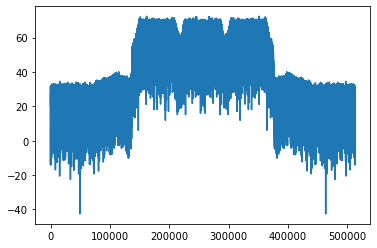

In [18]:
rx = wdm_sig.to('cpu').detach().numpy()
freq0 = torch.fft(rx_wdm_sig,1,True).to('cpu').detach().numpy()
freq0 = np.fft.fftshift(freq0[:,0]+1j*freq0[:,1])
freq0 = np.fft.fftshift(np.fft.fft(rx[:,0]+1j*rx[:,0] ))


plt.plot(20*np.log10(np.abs(freq0)))
# plt.plot(20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq)))
# plt.plot(20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq0)))

# print((20*np.log10(np.abs(freq0))- 20*np.log10(np.abs(freq)))[0:100])

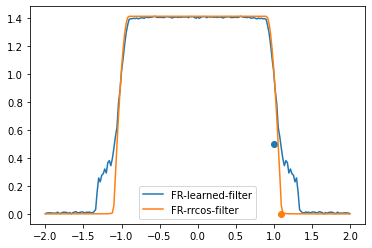

In [19]:
train_filter = my_filter(1)
learned_filter = train_filter.view(-1).to('cpu').detach().numpy()
# print(learned_filter)
learned_freq = np.fft.fftshift(np.fft.fft(learned_filter))
learned_freq = (np.abs(learned_freq))

rrc_filter = p_filter.view(-1).to('cpu').detach().numpy()
rrc_freq = np.fft.fftshift(np.fft.fft(rrc_filter))
rrc_freq = (np.abs(rrc_freq))

plt.figure()
plt.plot(np.linspace(-2,2, learned_freq.shape[0]),learned_freq, label='FR-learned-filter')
plt.plot(np.linspace(-2,2, rrc_freq.shape[0]),rrc_freq,label='FR-rrcos-filter')
plt.scatter(1.0,0.5)
plt.scatter(1.1,0)
plt.legend()

# a = np.linspace(-2,2,201)
# np.savetxt('learn_filter_1.05.txt', np.c_[a, learned_freq])

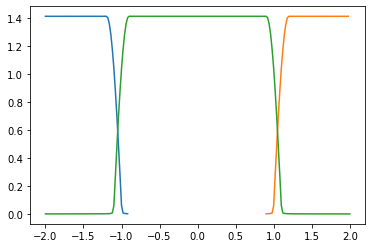

In [20]:
# a = np.linspace(-2,2,201)
a = np.linspace(-2,2,201)
# a = np.concatenate([a[0:49], a[150:None] ],-1)
# b = np.concatenate([rrc_freq[100:150], rrc_freq[100-50:100]],-1)
# np.savetxt('learn_filter_1.05.txt', np.c_[a, learned_freq])

plt.plot(a[0:55], rrc_freq[105:160], label='FR-learned-filter')
plt.plot(a[145:200], rrc_freq[40:95], label='FR-learned-filter')
plt.plot(a, rrc_freq, label='FR-learned-filter')
# np.savetxt('RRC_ch1.txt', np.c_[a[0:55], rrc_freq[105:160]])
# np.savetxt('RRC_ch2.txt', np.c_[a[145:200], rrc_freq[40:95]])

In [21]:
# a = torch.tensor(np.linspace(-1,1,10000)).view(-1,1).float().to(device)
# arc2 = my_arcsin(x1).to(device)

# eee = torch.asin(a).to('cpu').detach().numpy()/(np.pi/2)*1.35
# eee[eee>=1]=1
# eee[eee<=-1]=-1



# c = a.detach().to('cpu').detach().numpy()
# arc2 = arc2.detach().to('cpu').detach().numpy()


# plt.figure(figsize=(7.3, 5))
# plt.plot(c, arc2 ,label='NN3')
# # plt.plot(c, arc1 ,label='l-func')
# plt.plot(c,eee, '--', label='arcsin + clipping')
# plt.legend()
# plt.grid(True)
# plt.xlabel('Input')
# plt.ylabel('Output')



In [22]:
# gb_factor=1.04

# Path = 'Trained_models/0.1rolloff/AE-0.1rolloff-{}spacing'.format(gb_factor)
# checkpoint = torch.load(Path)
# encoder = Encoder(dims=[M,50,50,2]).to(device)
# decoder = Decoder(dims=[2,50,50,M]).to(device)
# my_filter = MyModel().to(device)
# my_arcsin = Arcsin_func().to(device)
# checkpoint = torch.load(Path)
# encoder.load_state_dict(checkpoint['64QAM_encoder'])
# decoder.load_state_dict(checkpoint['64QAM_decoder'])
# my_filter.load_state_dict(checkpoint['filter'])
# my_arcsin.load_state_dict(checkpoint['non_linear_function'])


In [23]:
# tx_mess1 = torch.from_numpy(np.arange(M)).to(device)
# one_hot1 = F.one_hot(tx_mess1).float() 

# sig1 = encoder2(one_hot1).to('cpu').detach().numpy()  
# sig2 = encoder(one_hot1).to('cpu').detach().numpy()  

# plt.figure(figsize=(5,5))
# plt.scatter(sig1[:,0], sig1[:,1])
# plt.scatter(sig2[:,0], sig2[:,1])
# plt.grid(True)

# x = np.arange(-1.2, 1.2, 0.004)
# xx, yy = np.meshgrid(x, x)
# x = xx.reshape(xx.size,1)
# y = yy.reshape(xx.size,1)
# xymesh = torch.from_numpy(np.concatenate((x, y), axis=1)).float().to(device)

# output = decoder(xymesh).to('cpu').detach().numpy()
# z = np.argmax(output, axis=-1).reshape(600,600)

# fig=plt.figure(figsize=(15,4))
# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)
# ax3.cla()
# ax3.pcolormesh(xx, yy, z)
# ax3.grid(True)
# ax3.set_xlim((-1.5, 1.5))
# ax3.set_ylim((-1.5, 1.5))
# ax3.set_ylabel('Quadraqure')
# ax3.set_xlabel('In-phase')


# # np.savetxt('const_before.txt', sig1)
# # np.savetxt('const_after.txt', sig2)

# plt.figure()
# filter1 = my_filter(1).view(-1).to('cpu').detach().numpy()  
# plt.plot(filter1)



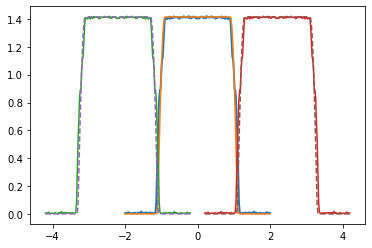

In [42]:
gb_factor=1.1

Path = 'Trained_models/0.1rolloff/AE-0.1rolloff-{}spacing'.format(gb_factor)
checkpoint = torch.load(Path)
encoder = Encoder(dims=[M,50,50,2]).to(device)
decoder = Decoder(dims=[2,50,50,M]).to(device)
my_filter = MyModel().to(device)
my_arcsin = Arcsin_func().to(device)
checkpoint = torch.load(Path)
encoder.load_state_dict(checkpoint['64QAM_encoder'])
decoder.load_state_dict(checkpoint['64QAM_decoder'])
my_filter.load_state_dict(checkpoint['filter'])
my_arcsin.load_state_dict(checkpoint['non_linear_function'])

a = np.linspace(-2,2,201)
filter1 = my_filter(1).view(-1).to('cpu').detach().numpy()  
learned_freq = np.abs(np.fft.fftshift(np.fft.fft(filter1)))
rrc_freq = np.abs(np.fft.fftshift(np.fft.fft(pulse1)))
plt.plot(a, learned_freq,  linewidth=2,)
plt.plot(a, rrc_freq, '-')
c = np.linspace(-4.2,-0.2, 201)
d =np.linspace(0.2,4.2, 201)
plt.plot(c, learned_freq)
plt.plot(d, learned_freq)
plt.plot(c, rrc_freq,'--')
plt.plot(d, rrc_freq,'--')

np.savetxt('learn_left_{}.txt'.format(gb_factor), np.c_[c, learned_freq])
np.savetxt('learn_right_{}.txt'.format(gb_factor), np.c_[d, learned_freq])
np.savetxt('rrc_left_{}.txt'.format(gb_factor), np.c_[c, rrc_freq])
np.savetxt('rrc_right_{}.txt'.format(gb_factor), np.c_[d, rrc_freq])

# a = np.linspace(-100,100,201)
# b = np.linspace(-2,2,201)
# np.savetxt('learn_filter_1.2.txt', np.c_[a, filter1])


In [ ]:
gb_factor

In [ ]:
# fig=plt.figure(figsize=(15,4))
# ax1 = fig.add_subplot(231)
# ax2 = fig.add_subplot(232)
# ax3 = fig.add_subplot(233)
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)

# ax1.plot(filter1,  linewidth=2,)
# ax1.plot(pulse1, '-')

# ax2.plot(filter2,  linewidth=2,)
# ax2.plot(pulse1, '-')


# ax3.plot(filter3,  linewidth=2,)
# ax3.plot(pulse1, '-')

# ax4.plot(learned_freq1,  linewidth=2,)
# ax4.plot(rrc_freq, '-')

# ax5.plot(learned_freq2,  linewidth=2,)
# ax5.plot(rrc_freq, '-')

# ax6.plot(learned_freq3,  linewidth=2,)
# ax6.plot(rrc_freq, '-')


# import tikzplotlib

# tikzplotlib.save("test.tex")


In [ ]:
# rx =single_sig[:,0]+1j*single_sig[:,1]
# freq = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rx))))
# plt.figure()
# plt.plot(np.linspace(-8,8,freq.shape[0]),freq)
# plt.title('PSD of one channel')
# plt.xlabel('normalized bandwidth')
# plt.ylabel('|P(f)|')


# rx = mul_sig[:,0]+1j*mul_sig[:,1]
# freq = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rx))))
# plt.figure()
# plt.plot(np.linspace(-8,8,freq.shape[0]),freq)
# plt.title('PSD of three channels')
# plt.xlabel('normalized bandwidth')
# plt.ylabel('|P(f)|')

# learned_filter = train_filter.view(-1).to('cpu').detach().numpy()
# learned_freq = np.fft.fftshift(np.fft.fft(learned_filter))
# learned_freq = (np.abs(learned_freq))

# rrc_filter = p_filter.view(-1).to('cpu').detach().numpy()
# rrc_freq = np.fft.fftshift(np.fft.fft(rrc_filter))
# rrc_freq = (np.abs(rrc_freq))

# plt.figure()
# plt.plot(np.linspace(-2,2, learned_freq.shape[0]),learned_freq, label='FR-learned-filter')
# plt.plot(np.linspace(-2,2, rrc_freq.shape[0]),rrc_freq,label='FR-rrcos-filter')
# plt.scatter(1.0,0.5)
# plt.scatter(1.1,0)
# plt.legend()

rx_sig = down_sig1.to('cpu').detach().numpy()
plt.figure(figsize=(6,6))
plt.scatter(rx_sig[:,0],rx_sig[:,1])
plt.xlabel('In-phase')
plt.ylabel('Quadraqure')

